# <center>Проект «Приоритизация гипотез и анализ A/B-теста»</center>

## Введение

В этом проекте мы разберемся, как увеличить выручку крупного интернет-магазина. В нашем распоряжении **три датасета**:
- перечень гипотез с показателями Reach, Impact, Confidence, Efforts;
- заказы, совершенные пользователями из разных групп A/B-теста;
- группы A/B-теста и количество пользователей.

**Наша цель** - определить наличие различий между группами A/B-теста и решить, нужно ли продолжать тест.

**Наш план работы**:
- познакомиться с данными;
- подготовить данные к анализу;
- приоритизировать гипотезы с помощью фреймворков ICE и RICE;
- проанализировать A/B-тест:
  - построить график кумулятивной выручки по группам;
  - построить график кумулятивного среднего чека по группам;
  - построить график относительного изменения кумулятивного среднего чека группы B к группе A;
  - построить график кумулятивного среднего количества заказов на посетителя по группам;
  - построить график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A;
  - построить точечный график количества заказов по пользователям;
  - посчитать 95-й и 99-й перцентили количества заказов на пользователя, выбрать границу для определения аномальных пользователей;
  - построить точечный график стоимостей заказов;
  - посчитать 95-й и 99-й перцентили стоимости заказов, выбрать границу для определения аномальных заказов;
  - посчитать статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным;
  - посчитать статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным;
  - посчитать статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным;
  - посчитать статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным;
  - принять решение по результатам теста.

## Знакомство с данными

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from scipy import stats as st
import numpy as np
import datetime as dt

In [2]:
hypothesis = pd.read_csv('hypothesis.csv')
orders = pd.read_csv('orders.csv')
visitors = pd.read_csv('visitors.csv')

In [3]:
display(hypothesis.head(5))
display(orders.head(5))
display(visitors.head(5))

print('hypothesis')
hypothesis.info()
print()
print('orders')
orders.info()
print()
print('visitors')
visitors.info()

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


hypothesis
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 492.0+ bytes

orders
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB

visitors
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data col

### Промежуточный вывод

У нас есть следующие данные:
- 9 гипотез с показателями Reach, Impact, Confidence, Efforts;
- заказы, совершенные пользователями из разных групп A/B-теста, на 1197 строк;
- группы A/B-теста и количество пользователей на 62 строки.

## Предобработка данных

Исправим названия столбцов в «змеином» регистре.

In [4]:
orders = orders.rename(
    columns={
        'transactionId': 'transaction_id',
        'visitorId': 'visitor_id'
    }
)

hypothesis.columns = hypothesis.columns.str.lower()


display(hypothesis.head(1))
display(orders.head(1))

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6


,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B


Проверим корректность типов данных.

In [5]:
print('hypothesis')
hypothesis.info()
print()
print('orders')
orders.info()
print()
print('visitors')
visitors.info()

hypothesis
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   hypothesis  9 non-null      object
 1   reach       9 non-null      int64 
 2   impact      9 non-null      int64 
 3   confidence  9 non-null      int64 
 4   efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 492.0+ bytes

orders
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   transaction_id  1197 non-null   int64 
 1   visitor_id      1197 non-null   int64 
 2   date            1197 non-null   object
 3   revenue         1197 non-null   int64 
 4   group           1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB

visitors
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
D

In [6]:
orders['transaction_id'] = orders['transaction_id'].astype('str')
orders['visitor_id'] = orders['visitor_id'].astype('str')
orders['date'] = pd.to_datetime(orders['date'])
visitors['date'] = pd.to_datetime(visitors['date'])

print('orders')
orders.info()
print()
print('visitors')
visitors.info()

orders
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transaction_id  1197 non-null   object        
 1   visitor_id      1197 non-null   object        
 2   date            1197 non-null   datetime64[ns]
 3   revenue         1197 non-null   int64         
 4   group           1197 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 46.9+ KB

visitors
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


Изменили тип данных в столбцах transaction_id и visitor_id в таблице orders на object, поскольку это категориальные переменные, и в столбцах date таблиц orders и visitors на datetime64.

Проверим данные на наличие пропущенных значений и дубликатов.

In [7]:
print(orders.isna().sum())
print(visitors.isna().sum())

transaction_id    0
visitor_id        0
date              0
revenue           0
group             0
dtype: int64
date        0
group       0
visitors    0
dtype: int64


In [8]:
print('Количество дубликатов в таблице orders:', orders.duplicated().sum())
print('Количество дубликатов в таблице visitors:', visitors.duplicated().sum())
print('Количество дубликатов в таблице orders по комбинации transaction_id и visitor_id:', orders[['transaction_id', 'visitor_id']].duplicated().sum())

Количество дубликатов в таблице orders: 0
Количество дубликатов в таблице visitors: 0
Количество дубликатов в таблице orders по комбинации transaction_id и visitor_id: 0


Пропусков и дубликатов мы не обнаружили.

### Промежуточный вывод

В итоге предобработки мы:
- скорректировали названия столбцов в «змеином» регистре;
- проверили и скорректировали типы данных в столбцах transaction_id и visitor_id таблицы orders на object и в столбцах date таблиц orders и visitors на datetime64;
- проверили данные на наличие пропущенных значений и дубликатов, их не обнаружилось.

## Приоритизация гипотез

Расшифруем названия столбцов в нашем датасете:
- reach — скольких пользователей затронет изменение, которое вы хотите внести;
- impact — насколько сильно изменение повлияет на пользователей, их опыт и удовлетворение от продукта;
- confidence — насколько вы уверены, что это изменение повлияет на пользователей именно так; 
- efforts — сколько стоит протестировать эту гипотезу. 

In [9]:
pd.set_option('max_colwidth', 120)
pd.set_option('display.width', 500)
display(hypothesis)

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


Применим фреймворк ICE для приоритизации гипотез.

In [10]:
hypothesis['ICE'] = round((hypothesis['impact']*hypothesis['confidence'])/hypothesis['efforts'], 2)
display(hypothesis[['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False))

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


В наибольшем приоритете у нас оказались гипотезы:
- 8 - Запустить акцию, дающую скидку на товар в день рождения
- 0 - Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей
- 7 - Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок

Применим фреймворк RICE и посмотрим, как изменилась приоритизация гипотез.

In [11]:
hypothesis['RICE'] = (hypothesis['reach']*hypothesis['impact']*hypothesis['confidence'])/hypothesis['efforts']
display(hypothesis[['hypothesis', 'RICE']].sort_values(by='RICE', ascending=False))

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


Теперь на первом месте гипотеза:
- 7 - Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок

А дальше идут:
- 2 - Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа
- 0 - Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей
- 6 - Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию

### Промежуточный вывод

В фреймворке RICE в отличие от ICE добавляется параметр Reach, то есть скольких пользователей затронет изменение.
Если в гипотезах `Запустить акцию, дающую скидку на товар в день рождения` и `Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей` высокие оценки в Impact и Confidence, что выводит их в топ, когда мы применяем ICE, то в гипотезах `Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок` и `Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа` высокая оценка у параметра Reach, то есть охват пользователей значительно выше, чем у первых двух. При этом у гипотезы `Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок` высокие оценки также в Impact и Confidence, что выводит ее в топ при применении обоих фреймворков.

Можно сделать вывод, что в первую очередь стоит обратить внимание на гипотезу - `Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок`.

## Анализ A/B-теста

### Проверка данных на нормальность

Проверим с помощью критерия Шапиро-Уилка, можно ли считать переменную revenue таблицы orders нормально распределённой.

Сформулируем гипотезы:
- **Нулевая гипотеза**: Переменная revenue таблицы orders распределена нормально.
- **Альтернативная гипотеза**: Переменная revenue таблицы orders распределена не нормально.

In [12]:
alpha = 0.05  # критический уровень статистической значимости

results_revenue = st.shapiro(orders['revenue'])
p_value_revenue = results_revenue[
    1
]  # второе значение в массиве результатов (с индексом 1) - p-value

print('p-значение: ', p_value_revenue)

if p_value_revenue < alpha:
    print('Отвергаем нулевую гипотезу: распределение не нормально')
else:
    print('Не получилось отвергнуть нулевую гипотезу, всё нормально') 

p-значение:  0.0
Отвергаем нулевую гипотезу: распределение не нормально


Таким же образом проверим переменную visitors таблицы visitors.

- **Нулевая гипотеза**: Переменная visitors таблицы visitors распределена нормально.
- **Альтернативная гипотеза**: Переменная visitors таблицы visitors распределена не нормально.

In [13]:
results_visitors = st.shapiro(visitors['visitors'])
p_value_visitors = results_visitors[
    1
]  # второе значение в массиве результатов (с индексом 1) - p-value

print('p-значение: ', p_value_visitors)

if p_value_visitors < alpha:
    print('Отвергаем нулевую гипотезу: распределение не нормально')
else:
    print('Не получилось отвергнуть нулевую гипотезу, всё нормально') 

p-значение:  0.00202026404440403
Отвергаем нулевую гипотезу: распределение не нормально


Обе переменные распределены не нормально.

### Графики по выручке

Выясним даты проведения теста и количество уникальных пользователей в каждой группе, а также проверим, не пересекаются ли пользователи в этих группах.

In [14]:
print('Начало теста:', orders['date'].min()) 
print('Окончание теста:', orders['date'].max())
orders.groupby('group').agg({'visitor_id':'nunique'})


Начало теста: 2019-08-01 00:00:00
Окончание теста: 2019-08-31 00:00:00


,visitor_id
group,
A,503
B,586


In [15]:
common_users = list(set(orders.query('group == "A"')['visitor_id']).intersection(orders.query('group == "B"')['visitor_id']))
len(common_users)

58

В нашем тесте участвует две группы пользователей - A и B. В группе A - 503 пользователя, в группе B - 586, при этом 58 из них попали в обе группы. Чтобы исключить искажение данных, мы удалим этих пользователей из таблицы.

In [16]:
orders = orders.query('visitor_id not in @common_users')
orders.groupby('group').agg({'visitor_id':'nunique'})

,visitor_id
group,
A,445
B,528


После удаления совпадающих пользователей в группе A - 445 пользователей, а в группе B - 528.

Начало теста - 2019-08-01.

Окончание теста - 2019-08-31.

Построим графики кумулятивной выручки и кумулятивного среднего чека по группам, а также график относительного изменения кумулятивного среднего чека группы B к группе A, но сначала подготовим данные.

In [17]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates()

# получаем агрегированные кумулятивные по дням данные о заказах 
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'transaction_id' : 'nunique', 'visitor_id' : 'nunique', 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

print(cumulativeData.head(5))


        date group  orders  buyers  revenue  visitors
0 2019-08-01     A      23      19   142779       719
1 2019-08-01     B      17      17    59758       713
2 2019-08-02     A      42      36   234381      1338
3 2019-08-02     B      40      39   221801      1294
4 2019-08-03     A      66      60   346854      1845


Построим **график кумулятивной выручки по группам**.

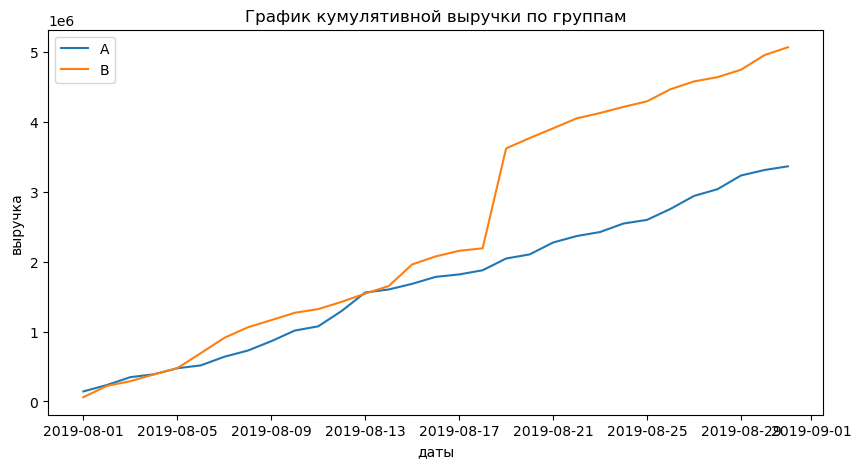

In [18]:
# задаём размер сетки для графиков
plt.figure(figsize=(10, 5))

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.title('График кумулятивной выручки по группам')
plt.xlabel('даты')
plt.ylabel('выручка')
plt.legend()
plt.show()

Выручка группы B резко выросла во второй половине теста по сравнению с группой A, это может сигнализировать о всплесках числа заказов либо о появлении очень дорогих заказов в выборке.

Построим **график кумулятивного среднего чека по группам**.

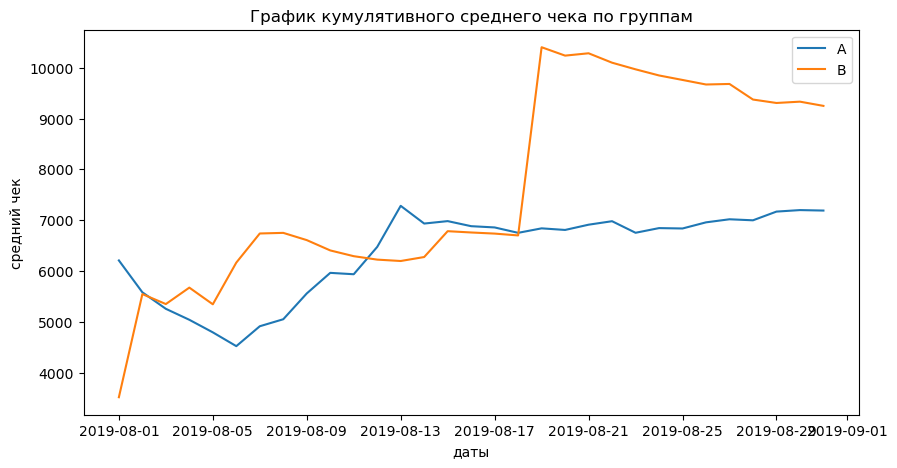

In [19]:
# задаём размер сетки для графиков
plt.figure(figsize=(10, 5))

plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.title('График кумулятивного среднего чека по группам')
plt.xlabel('даты')
plt.ylabel('средний чек')
plt.legend()
plt.show()

Средний чек для группы A установился на одном уровне, а для группы B резко вырос во второй половине теста и постепенно падает. Возможно, в группу B во второй половине теста попали крупные заказы, тогда ей нужно больше данных, чтобы прийти к реальному среднему чеку и установиться на его уровне.

Построим **график относительного изменения кумулятивного среднего чека группы B к группе A**.

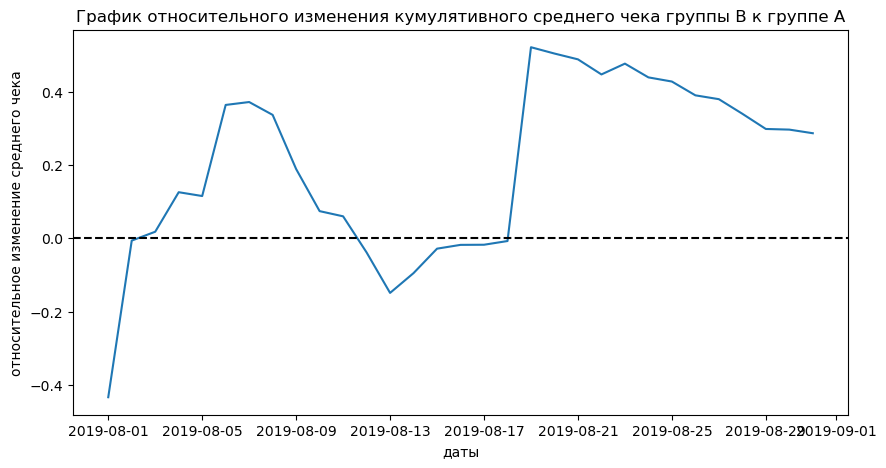

In [20]:
# задаём размер сетки для графиков
plt.figure(figsize=(10, 5))

# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')

plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.xlabel('даты')
plt.ylabel('относительное изменение среднего чека')
plt.show()

В нескольких точках график различия между сегментами резко «скачет», где-то точно спрятались крупные заказы и выбросы.

### Графики по количеству заказов

Теперь построим графики кумулятивного среднего количества заказов на посетителя по группам и относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A.

Построим **график кумулятивного среднего количества заказов на посетителя по группам**.

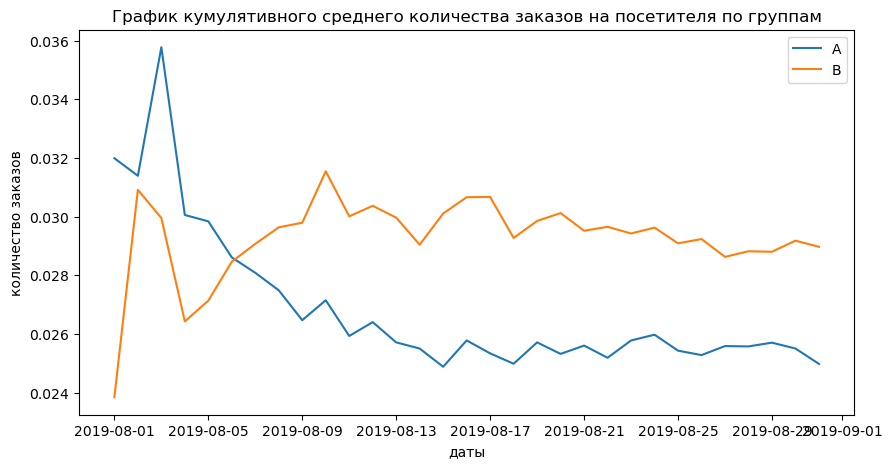

In [21]:
# считаем среднее количество заказов на посетителя
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# задаём размер сетки для графиков
plt.figure(figsize=(10, 5))

# строим графики
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.title('График кумулятивного среднего количества заказов на посетителя по группам')
plt.xlabel('даты')
plt.ylabel('количество заказов')
plt.legend()
plt.show()

Среднее количество заказов у группы B значительно выше, чем у группы A. Значения обеих групп зафиксировались.

Построим **график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A**.

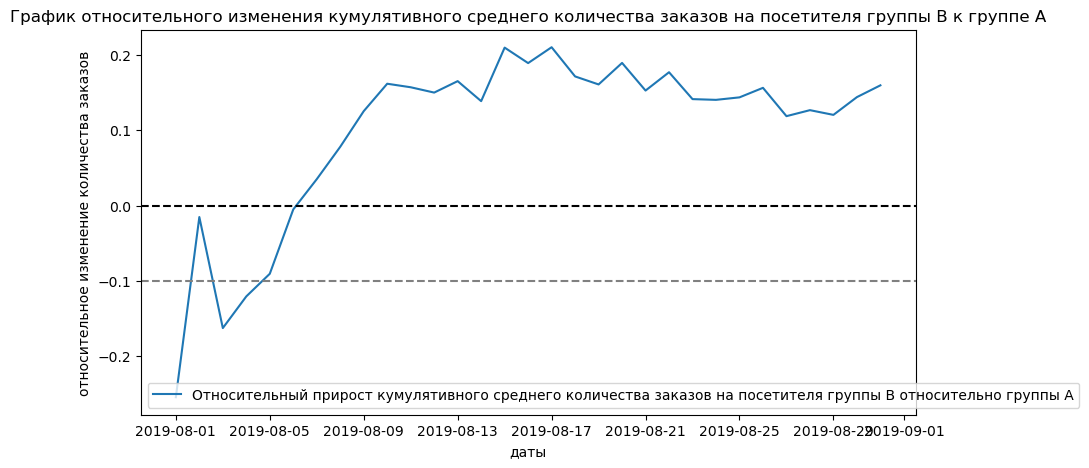

In [22]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# задаём размер сетки для графиков
plt.figure(figsize=(10, 5))

plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Относительный прирост кумулятивного среднего количества заказов на посетителя группы B относительно группы A")
plt.legend()

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=-0.1, color='grey', linestyle='--')

plt.title('График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A')
plt.xlabel('даты')
plt.ylabel('относительное изменение количества заказов')
plt.show()

Прирост кумулятивного среднего в группе B сильно опередил группу A еще в первой половине теста, затем немного пошел на спад, все еще опережая группу A.

### Анализ выбросов и всплесков

Построим точечный график количества заказов по пользователям и стоимостей заказов, посчитаем 95-й и 99-й перцентили и выберем границу для определения аномальных пользователей и аномальных заказов.

Построим точечную диаграмму числа заказов на одного пользователя и посчитаем выборочные перцентили.

     visitor_id  orders
507  2988190573       3
376   249864742       3
442  2742574263       3
274  2108163459       3
749  3967698036       3
729  3908431265       3
866   611059232       3
614  3362039251       2
907   759473111       2
306  2232111114       2


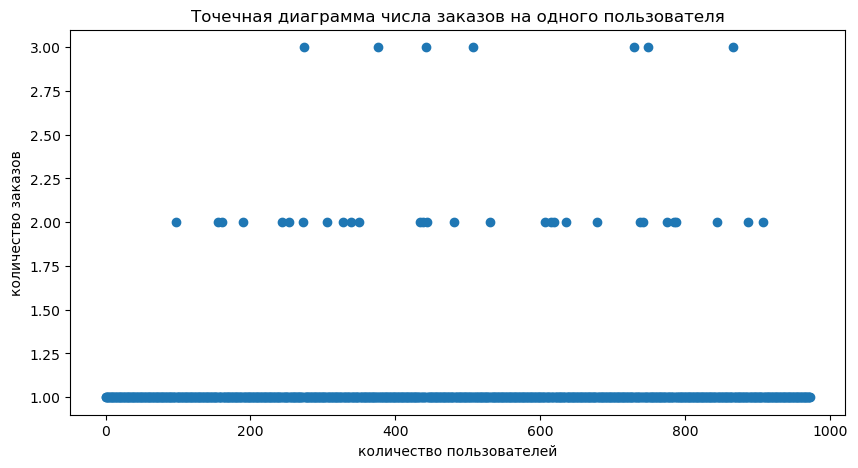

In [23]:
ordersByUsers = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)

ordersByUsers.columns = ['visitor_id', 'orders']

print(ordersByUsers.sort_values(by='orders', ascending=False).head(10)) 

# задаём размер сетки для графиков
plt.figure(figsize=(10, 5))

x_values = pd.Series(range(0,len(ordersByUsers)))

plt.scatter(x_values, ordersByUsers['orders']) 
plt.title('Точечная диаграмма числа заказов на одного пользователя')
plt.xlabel('количество пользователей')
plt.ylabel('количество заказов')
plt.show()

In [24]:
print('Перцентили 90, 95, 99:', np.percentile(ordersByUsers['orders'], [90, 95, 99])) 

Перцентили 90, 95, 99: [1. 1. 2.]


Не больше 5% пользователей совершали больше 1 заказа, и не больше 1% пользователей совершали больше 2 заказов. Будем считать аномальными пользователей, совершивших больше 1 заказа.

Изучим точечную диаграмму распределения стоимостей заказов.

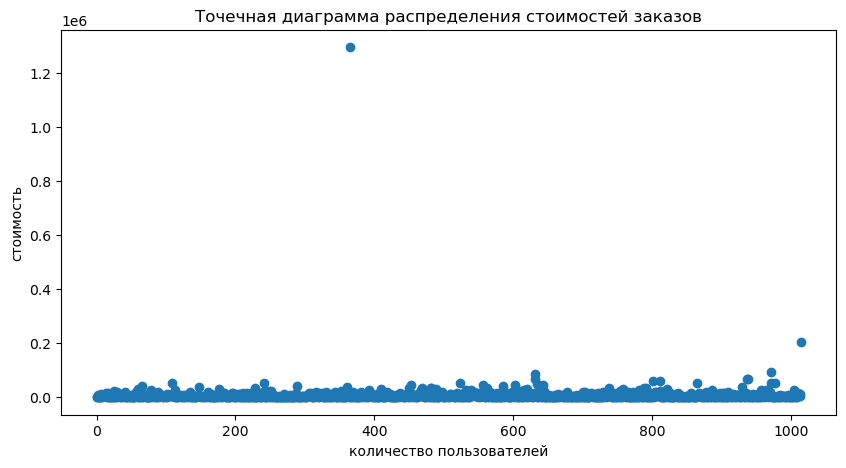

In [25]:
# задаём размер сетки для графиков
plt.figure(figsize=(10, 5))

x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])
plt.title('Точечная диаграмма распределения стоимостей заказов')
plt.xlabel('количество пользователей')
plt.ylabel('стоимость')
plt.show()

Как мы и предполагали, есть немного дорогих заказов. Определим 90, 95 и 99 перцентили среднего чека в выборке.

In [26]:
print(np.percentile(orders['revenue'], [90, 95, 99]))

[17990. 26785. 53904.]


Не более 5% заказов дороже 26 785 рублей и не более 1% дороже 53 904 рублей. Будем считать аномальными заказы дороже 26 785 рублей.

### Статистическая значимость

#### Различия по «сырым» данным

Посчитаем статистическую значимость различий в среднем числе заказов на пользователя и среднем чеке между группами по «сырым» данным — без удаления аномальных пользователей.

Будем использовать критерий Манна-Уитни, поскольку наши переменные распределены не нормально, а значит, алгебраические метрики будут работать плохо, одно выбивающееся значение может существенно повлиять на результат. Критерий Манна-Уитни основан на структурном подходе и работает с рангами, никак не учитывая сами значения.

Сформулируем гипотезы:
- **Нулевая гипотеза**: различий в среднем количестве заказов на пользователя между группами нет. 
- **Альтернативная гипотеза**: различия в среднем количестве заказов на пользователя между группами есть.

In [27]:
# для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitor_id', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitor_id', 'orders']

# Объявим переменные, в которых пользователям из разных групп будет соответствовать количество заказов
sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitors.query('group == "A"')['visitors'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitors.query('group == "B"')['visitors'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

# Применим критерий Манна-Уитни и отформатируем p-value, округлив его до трёх знаков после запятой
print('p-value:', "{0:.3f}".format(st.mannwhitneyu(sampleA, sampleB)[1]))

print('Относительный прирост среднего числа заказов группы B:', "{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))


p-value: 0.011
Относительный прирост среднего числа заказов группы B: 0.160


Первое число — p-value = 0.011 меньше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в среднем числе заказов на пользователя между группами нет, отвергаем. Относительный рост группы B равен 16% — второе число в выводе.

Теперь проверим статистическую значимость различий в среднем чеке между сегментами.
- **Нулевая гипотеза**: различий в среднем чеке между группами нет. 
- **Альтернативная гипотеза**: различия в среднем чеке между группами есть.

In [28]:
print('p-value:', '{0:.3f}'.format(st.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('Относительный прирост среднего чека группы B:', '{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

p-value: 0.829
Относительный прирост среднего чека группы B: 0.287


P-value значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. Впрочем, средний чек группы B значительно выше среднего чека группы A.

#### Различия по «очищенным» данным

Теперь посчитаем статистическую значимость различий в среднем числе заказов на пользователя и среднем чеке между группами по «очищенным» данным.

Узнаем, сколько всего аномальный пользователей.

In [29]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > np.percentile(ordersByUsers['orders'], 95)]['visitor_id'],
        ordersByUsersB[ordersByUsersB['orders'] > np.percentile(ordersByUsers['orders'], 95)]['visitor_id'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > np.percentile(orders['revenue'], 95)]['visitor_id']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.head(5))
print(abnormalUsers.shape[0])

551     1010866419
568      113298937
1103    1164614297
137     1211585711
1136    1307669133
Name: visitor_id, dtype: object
86


In [30]:
round(len(abnormalUsers)/orders['visitor_id'].nunique()*100, 2)

8.84

Всего 86 аномальных пользователей, это 8,84% от общего количества пользователей.

Узнаем, как их действия повлияли на результаты теста. Сначала подготовим выборки количества заказов по пользователям по группам теста.

In [31]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['visitor_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitors.query('group == "A"')['visitors'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitor_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitors.query('group == "B"')['visitors'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)



Применим статистический критерий Манна-Уитни к полученным выборкам.

In [32]:
print('p-value:', '{0:.3f}'.format(st.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('Относительный прирост среднего числа заказов группы B:', '{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

p-value: 0.016
Относительный прирост среднего числа заказов группы B: 0.174


P-value и относительный рост группы B стали немного выше.

In [33]:
print(
    'p-value:', '{0:.3f}'.format(
        st.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    'Относительный прирост среднего чека группы B:', "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
)

p-value: 0.727
Относительный прирост среднего чека группы B: -0.034


P-value стал ниже, а относительный прирост среднего чека группы B даже стал отрицательным: -3,4%.

### Промежуточный вывод

- Мы проверили с помощью **критерия Шапиро-Уилка** переменные revenue таблицы orders и visitors таблицы visitors. Обе переменные распределены не нормально.
- Построив **графики по выручке**, мы увидели, что:
   - Выручка группы B резко выросла во второй половине теста по сравнению с группой A, это может сигнализировать о всплесках числа заказов либо о появлении очень дорогих заказов в выборке.
   - Средний чек для группы A установился на одном уровне, а для группы B резко вырос во второй половине теста и постепенно падает. Возможно, в группу B во второй половине теста попали крупные заказы, тогда ей нужно больше данных, чтобы прийти к реальному среднему чеку и установиться на его уровне.
   - В нескольких точках график различия между сегментами резко «скачет», где-то точно спрятались крупные заказы и выбросы.
- Рассмотрев **графики по количеству заказов**, мы выяснили, что:
   - Среднее количество заказов у группы B значительно выше, чем у группы A. Значения обеих групп зафиксировались.
   - Прирост кумулятивного среднего в группе B сильно опередил группу A еще в первой половине теста, затем немного пошел на спад, все еще опережая группу A.
- Провели **анализ выбросов и всплесков**:
   - Не больше 5% пользователей совершали больше 1 заказа, и не больше 1% пользователей совершали больше 2 заказов. Будем считать аномальными пользователей, совершивших больше 1 заказа.
   - Не более 5% заказов дороже 26 785 рублей и не более 1% дороже 53 904 рублей. Будем считать аномальными заказы дороже 26 785 рублей.
- Посчитали **статистическую значимость по «сырым» данным**:
   - Сформулировали гипотезы для среднего количества заказов:
      - ***Нулевая гипотеза***: различий в среднем количестве заказов на пользователя между группами нет.
      - ***Альтернативная гипотеза***: различия в среднем количестве заказов на пользователя между группами есть.
   - P-value = 0.011 меньше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в среднем числе заказов на пользователя между группами нет, отвергаем. Относительный рост группы B равен 16%.
   - Сформулировали гипотезы для среднего чека:
      - ***Нулевая гипотеза***: различий в среднем чеке между группами нет.
      - ***Альтернативная гипотеза***: различия в среднем чеке между группами есть.
   - P-value значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. Впрочем, средний чек группы B значительно выше среднего чека группы A.
- Посчитали **статистическую значимость по «очищенным» данным**.
   - По среднему числу заказов: P-value и относительный рост группы B стали немного выше. Нулевую гипотезу все так же отвергаем, различия в группах есть.
   - По среднему чеку: P-value стал ниже, а относительный прирост среднего чека группы B даже стал отрицательным: -3,4%. Нулевую гипотезу не отвергаем, различий в группах нет.

**В итоге мы имеем следующие факты**:
- Есть статистически значимое различие по среднему количеству заказов между группами как по «сырым», так и по данным после фильтрации аномалий;
- Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий;
- График различия среднего количества заказов на посетителя между группами сообщает, что результаты группы B лучше группы A, и значения зафиксировались.
- График различия среднего чека говорит о том, что результаты группы B лучше группы A, но постепенно идут на спад.

Исходя из обнаруженных фактов, результаты группы B значительно превосходят группу A.

## Общий вывод

В этом проекте мы **познакомились с данными**:
- 9 гипотез с показателями Reach, Impact, Confidence, Efforts;
- заказы, совершенные пользователями из разных групп A/B-теста, на 1197 строк;
- группы A/B-теста и количество пользователей на 62 строки.

Провели **предобработку данных**:
- скорректировали названия столбцов в «змеином» регистре;
- проверили и скорректировали типы данных в столбцах transaction_id и visitor_id таблицы orders на object и в столбцах date таблиц orders и visitors на datetime64;
- проверили данные на наличие пропущенных значений и дубликатов, их не обнаружилось.

**Приоритизировали гипотезы**:
- В фреймворке RICE в отличие от ICE добавляется параметр Reach, то есть скольких пользователей затронет изменение.
Если в гипотезах `Запустить акцию, дающую скидку на товар в день рождения` и `Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей` высокие оценки в Impact и Confidence, что выводит их в топ, когда мы применяем ICE, то в гипотезах `Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок` и `Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа` высокая оценка у параметра Reach, то есть охват пользователей значительно выше, чем у первых двух. При этом у гипотезы `Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок` высокие оценки также в Impact и Confidence, что выводит ее в топ при применении обоих фреймворков.
- Можно сделать вывод, что в первую очередь стоит обратить внимание на гипотезу - `Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок`.

**Провели A/B-тест**:
- Мы проверили с помощью **критерия Шапиро-Уилка** переменные revenue таблицы orders и visitors таблицы visitors. Обе переменные распределены не нормально.
- Построив **графики по выручке**, мы увидели, что:
   - Выручка группы B резко выросла во второй половине теста по сравнению с группой A, это может сигнализировать о всплесках числа заказов либо о появлении очень дорогих заказов в выборке.
   - Средний чек для группы A установился на одном уровне, а для группы B резко вырос во второй половине теста и постепенно падает. Возможно, в группу B во второй половине теста попали крупные заказы, тогда ей нужно больше данных, чтобы прийти к реальному среднему чеку и установиться на его уровне.
   - В нескольких точках график различия между сегментами резко «скачет», где-то точно спрятались крупные заказы и выбросы.
- Рассмотрев **графики по количеству заказов**, мы выяснили, что:
   - Среднее количество заказов у группы B значительно выше, чем у группы A. Значения обеих групп зафиксировались.
   - Прирост кумулятивного среднего в группе B сильно опередил группу A еще в первой половине теста, затем немного пошел на спад, все еще опережая группу A.
- Провели **анализ выбросов и всплесков**:
   - Не больше 5% пользователей совершали больше 1 заказа, и не больше 1% пользователей совершали больше 2 заказов. Будем считать аномальными пользователей, совершивших больше 1 заказа.
   - Не более 5% заказов дороже 26 785 рублей и не более 1% дороже 53 904 рублей. Будем считать аномальными заказы дороже 26 785 рублей.
- Посчитали **статистическую значимость по «сырым» данным**:
   - Сформулировали гипотезы для среднего количества заказов:
      - ***Нулевая гипотеза***: различий в среднем количестве заказов на пользователя между группами нет.
      - ***Альтернативная гипотеза***: различия в среднем количестве заказов на пользователя между группами есть.
   - P-value = 0.011 меньше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в среднем числе заказов на пользователя между группами нет, отвергаем. Относительный рост группы B равен 16%.
   - Сформулировали гипотезы для среднего чека:
      - ***Нулевая гипотеза***: различий в среднем чеке между группами нет.
      - ***Альтернативная гипотеза***: различия в среднем чеке между группами есть.
   - P-value значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. Впрочем, средний чек группы B значительно выше среднего чека группы A.
- Посчитали **статистическую значимость по «очищенным» данным**.
   - По среднему числу заказов: P-value и относительный рост группы B стали немного выше. Нулевую гипотезу все так же отвергаем, различия в группах есть.
   - По среднему чеку: P-value стал ниже, а относительный прирост среднего чека группы B даже стал отрицательным: -3,4%. Нулевую гипотезу не отвергаем, различий в группах нет.

**В итоге мы имеем следующие факты**:
- Есть статистически значимое различие по среднему количеству заказов между группами как по «сырым», так и по данным после фильтрации аномалий;
- Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий;
- График различия среднего количества заказов на посетителя между группами сообщает, что результаты группы B лучше группы A, и значения зафиксировались.
- График различия среднего чека говорит о том, что результаты группы B лучше группы A, но постепенно идут на спад.

Исходя из обнаруженных фактов, результаты группы B значительно превосходят группу A.